In [29]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Freeman & Fried (2011), Fig. 2

In [2]:
# Data extracted from Fig. 2 of Freeman & Fried (2011)
freeman = dict()

# From Figure 2A
freeman['norm_resp'] = dict()
freeman['norm_resp']['2'] = np.array([1.00000, 1.00000, 2.02247, 0.71475,
                                        2.98876, 0.68852, 3.95506, 0.65902,
                                        4.94382, 0.63934, 5.91011, 0.62623,
                                        6.89888, 0.62951, 7.88764, 0.62951,
                                        8.87640, 0.62623, 9.86517, 0.61311]).reshape((-1, 2))
freeman['norm_resp']['4'] = np.array([1.00000, 1.00000, 1.97753, 0.69836,
                                        2.98876, 0.60656, 3.95506, 0.58361,
                                        4.92135, 0.54098, 5.91011, 0.52787,
                                        6.89888, 0.53443, 7.93258, 0.52131,
                                        8.89888, 0.51148, 9.86517, 0.51148]).reshape((-1, 2))
freeman['norm_resp']['8'] = np.array([1.00000, 1.00000, 1.97753, 0.59672,
                                        3.03371, 0.52787, 3.97753, 0.47869,
                                        4.94382, 0.43607, 5.93258, 0.43279,
                                        6.92135, 0.40984, 7.88764, 0.37377,
                                        8.87640, 0.38689, 9.86517, 0.36721]).reshape((-1, 2))
freeman['norm_resp']['16'] = np.array([1.03371, 0.98361, 2.00000, 0.66557,
                                         2.98876, 0.48525, 3.97753, 0.42295,
                                         4.96629, 0.37049, 5.93258, 0.32787,
                                         6.92135, 0.31475, 7.93258, 0.29508,
                                         8.87640, 0.28197, 9.91011, 0.28197]).reshape((-1, 2))

# From Figure 8A
freeman['long_term'] = np.array([0.08333, 3.76415, 0.08333, 3.56604,
                                 0.05556, 3.24528, 0.08333, 2.96226,
                                 0.11111, 2.60377, 0.19444, 2.34906,
                                 0.19444, 2.11321, 0.27778, 1.83019,
                                 0.41667, 1.63208, 0.91667, 1.50000,
                                 2.08333, 1.43396, 3.72222, 1.36792,
                                 5.94444, 1.30189, 8.11111, 1.26415,
                                 10.55556, 1.18868, 12.83333, 1.13208,
                                 15.16667, 1.08491, 17.19444, 1.05660,
                                 18.50000, 1.07547]).reshape((-1, 2))

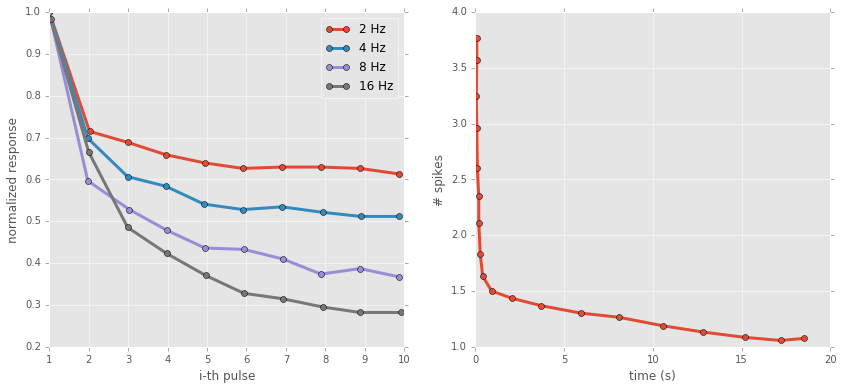

In [3]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
for cond in ['2', '4', '8', '16']:
    plt.plot(freeman['norm_resp'][cond][:, 0], freeman['norm_resp'][cond][:, 1], 'o-',
             linewidth=3, label=cond + ' Hz')
plt.xlabel('i-th pulse')
plt.ylabel('normalized response')
plt.legend()

plt.subplot(122)
plt.plot(freeman['long_term'][:, 0], freeman['long_term'][:, 1], 'o-', linewidth=3)
plt.xlabel('time (s)')
plt.ylabel('# spikes')

# Fitting their plot
----------------------------

Just trying to make sure I got the double exponent right. Trying to fit their data from Fig. 8A.

In [4]:
def double_exp(x, k1, tau1, k2, tau2):
    return k1 * np.exp(-x * tau1) + k2 * np.exp(-x * tau2)

In [5]:
def mse_double_exp(x):
    [k1, tau1, k2, tau2] = x
    
    xtest = freeman['long_term'][:, 0]
    ytest = freeman['long_term'][:, 1]
    
    yhat = double_exp(xtest, k1, tau1, k2, tau2)
    return np.mean(np.abs(yhat - ytest) ** 2)

In [6]:
res = minimize(mse_double_exp, [1.0, 0.15, 1.0, 14.0], method='Nelder-Mead')
k1, tau1, k2, tau2 = res.x
print('k1 = %.4f' % k1)
print('tau1 = %.4f' % tau1)
print('k2 = %.4f' % k2)
print('tau2 = %.4f' % tau2)

k1 = 1.4728
tau1 = 0.0191
k2 = 3.1402
tau2 = 7.1345


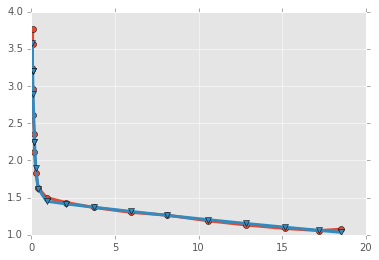

In [7]:
plt.plot(freeman['long_term'][:, 0], freeman['long_term'][:, 1], 'o-', linewidth=3)
plt.plot(freeman['long_term'][:, 0], double_exp(freeman['long_term'][:, 0], k1, tau1, k2, tau2),
         'v-', linewidth=3)

# Model
-----------------

Following are all utily funcions used in this script.

In [8]:
class GanglionCell(object):
    def __init__(self, tsample, ca1_scale=1.0, ca1_tau=0.0191, ca2_scale=1.0, ca2_tau=14.0,
                 sig_a=0.0, sig_b=10.0, sig_c=0.0, sig_d=1.0):
#                  out_scale=1.0, out_bias=0.0):
        assert ca1_scale > 0
        assert ca2_scale > 0
        assert ca1_tau > 0
        assert ca2_tau >0
#         assert out_scale > 0
        self.ca1_tau = ca1_tau
        self.ca2_tau = ca2_tau
        self.ca1_scale = ca1_scale
        self.ca2_scale = ca2_scale
#         self.out_scale= out_scale
#         self.out_bias = out_bias
        self.tsample = tsample
        self.sig_a = sig_a
        self.sig_b = sig_b
        self.sig_c = sig_c
        self.sig_d = sig_d

        self.tau_nfl = 0.42 / 1000
        t = np.arange(0, 10 * self.tau_nfl, self.tsample)
        self.gamma_nfl = e2cm.gamma(1, self.tau_nfl, t)
        self.gamma_nfl /= np.trapz(self.gamma_nfl, dx=self.tsample)

        t = np.arange(0, 10 * self.ca1_tau, self.tsample)
        self.gamma_ca_fast = e2cm.gamma(1, self.ca1_tau, t)
        self.gamma_ca_fast /= np.trapz(self.gamma_ca_fast, dx=self.tsample)

#         t = np.arange(0, 10 * self.ca2_tau, self.tsample)
#         self.gamma_ca_slow = e2cm.gamma(1, self.ca2_tau, t)
#         self.gamma_ca_slow /= np.trapz(self.gamma_ca_slow, dx=self.tsample)

        
    def model_cascade(self, pt, dolayers=None, dojit=True):
        assert pt.tsample == self.tsample
        
        self.stim = pt
        self.ca_fast = pt.tsample * fftconvolve(np.abs(pt.data),
                                                  self.gamma_ca_fast, mode='full')[:pt.data.size]
#         self.ca_slow = pt.tsample * fftconvolve(np.abs(pt.data),
#                                                   self.gamma_ca_slow, mode='full')[:pt.data.size]

        self.r_impulse = pt.tsample * fftconvolve(pt.data, self.gamma_nfl)[:pt.data.size]
        
        self.r_adj = self.r_impulse - self.ca1_scale * self.ca_fast #- self.ca2_scale * self.ca_slow
        
#         self.r_rgc = np.maximum(0, self.r_adj * self.out_scale + self.out_bias)
        self.r_rgc = self.sig_a + (self.sig_b - self.sig_a) / (1.0 + np.exp((self.sig_c - self.r_adj) * self.sig_d))
        
        return utils.TimeSeries(pt.tsample, self.r_rgc)

# Fit
----------

In [38]:
def get_model(x):
    tsample = 0.005 / 1000

    [k1, k2, a, b, c, d] = x
    model = dict()
    
    # Stimulating electrode remained 25um above the inner limiting membrane
    model['implant'] = e2cm.ElectrodeArray('epiretinal', 40.0 / 2, -500, -500, 25.0)

    r_sampling = 100
    axon_lambda = 2 
    model['retina'] = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                                  xlo=implant[0].x_center, xhi=implant[0].x_center,
                                  ylo=implant[0].y_center, yhi=implant[0].y_center)

    model['gcr'] = GanglionCell(tsample, ca1_scale=k1, ca1_tau=0.1764, ca2_scale=k2, ca2_tau=14.0,
                                sig_a=a, sig_b=b, sig_c=c, sig_d=d)
    
    return model

In [9]:
def run_exp1(x, model, freqs=[2, 4, 8, 16]):
    [k1, tau1, a, b, c, d] = x
    pdur = 1.0 / 1000
    amp = 1.0
    num_pulses = 10
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1['freqs'] = freqs
    for freq in freqs:
        cond = str(freq)
        exp1[cond] = dict()
        
        stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=float(num_pulses) / freq,
                                      pulse_dur=pdur, interphase_dur=0,
                                      pulsetype='cathodicfirst',
                                      delay=20.0 / 1000)
        mov = gcr.model_cascade(stim)
        exp1[cond]['gcr'] = gcr
        exp1[cond]['mov'] = mov
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / float(num_pulses))
        peaks = []
        for f in range(num_pulses):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        exp1[cond]['resp'] = peaks
        exp1[cond]['norm_resp'] = peaks / (peaks[0] + np.finfo(float).eps)
        
    return exp1

In [10]:
def mse_model_exp1(x, freeman, freqs):
    model = get_model(x)
    exp1 = run_exp1(x, model, freqs)
    
    mse = 0
    for freq in exp1['freqs']:
        cond = str(freq)
        mse += np.mean(np.abs(exp1[cond]['resp'] - freeman['norm_resp'][cond][:, 1]) ** 2)
    
    print('%s: %.7f' % (str([('%.7f' % x) for x in res.x]), mse))
    return mse

In [11]:
freqs = [2, 4, 8, 16]

In [24]:
res = minimize(mse_model_exp1, [1.0, 0.3, 0.0, 10.0, 0.0, 5.0], args=(freeman, freqs),
               method='L-BFGS-B', bounds=[(0.01, 10.0), (0.01, 1.0),
                                          (-10.0, 0.3), (0.3, 100.0),
                                          (-10.0, 10.0), (0.01, 10.0)])

[  1.    0.3   0.   10.    0.    5. ]: 343.92094
[  1.00000001   0.3          0.          10.           0.           5.        ]: 343.92094
[  1.           0.30000001   0.          10.           0.           5.        ]: 343.92094
[  1.00000000e+00   3.00000000e-01   1.00000000e-08   1.00000000e+01
   0.00000000e+00   5.00000000e+00]: 343.92094
[  1.           0.3          0.          10.00000001   0.           5.        ]: 343.92094
[  1.00000000e+00   3.00000000e-01   0.00000000e+00   1.00000000e+01
   1.00000000e-08   5.00000000e+00]: 343.92094
[  1.           0.3          0.          10.           0.           5.00000001]: 343.92094
[  1.90831804   0.01        -1.27453177   1.          10.           0.01      ]: 2.38780
[  1.90831805   0.01        -1.27453177   1.          10.           0.01      ]: 2.38780
[  1.90831804   0.01000001  -1.27453177   1.          10.           0.01      ]: 2.38780
[  1.90831804   0.01        -1.27453176   1.          10.           0.01      ]: 2.38780

# Plot
----------

In [25]:
print(res)

      fun: 0.012760847960087165
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.22884168e-03,   3.58128804e-04,   8.46524933e-04,
        -3.84119819e-06,   1.58740382e-03,  -1.16033554e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2576
      nit: 267
   status: 0
  success: True
        x: array([ 10.        ,   0.66614856,   0.08488603,  79.90961953,
         1.25546999,  10.        ])


In [26]:
test_freqs = [2, 4, 8, 16]
model = run_model(res.x, implant, retina, test_freqs)

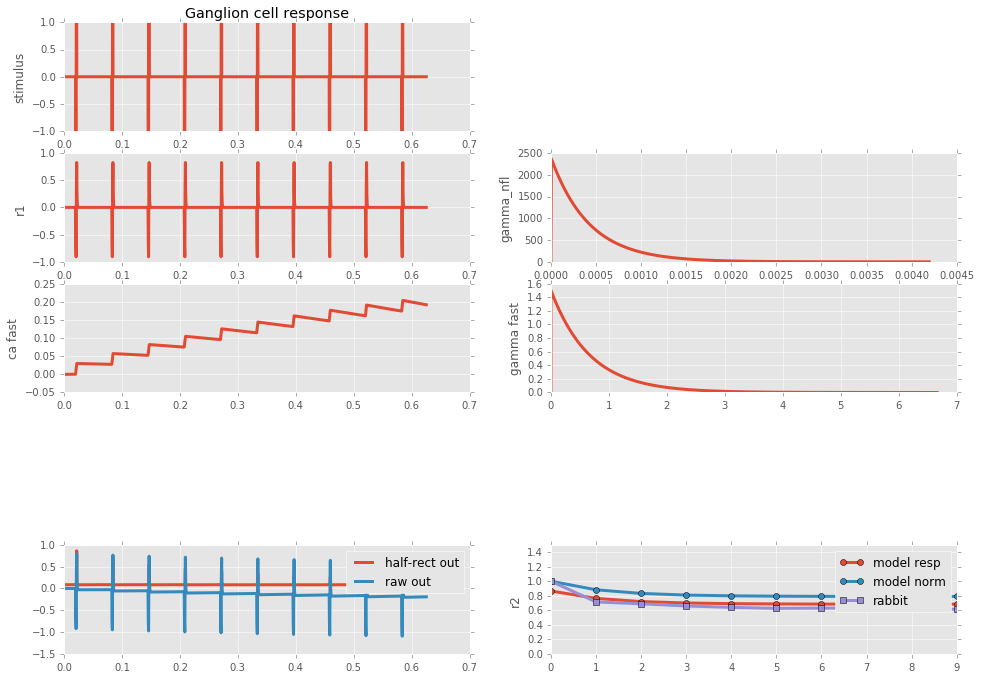

In [27]:
cond = str(test_freqs[0])

gcr = model[cond]['gcr']
tstim = np.arange(gcr.stim.data.size) * gcr.stim.tsample

plt.figure(figsize=(16, 16))
freq = 8.0

plt.subplot(721)
plt.plot(tstim, gcr.stim.data, linewidth=3)
plt.title('Ganglion cell response')
plt.ylabel('stimulus')

# Fast response
plt.subplot(723)
plt.plot(tstim, gcr.r_impulse, linewidth=3)
plt.ylabel('r1')

plt.subplot(724)
tgamma = np.arange(gcr.gamma_nfl.size) * gcr.stim.tsample
plt.plot(tgamma, gcr.gamma_nfl, linewidth=3)
plt.ylabel('gamma_nfl')

# Fast desensitization
plt.subplot(725)
plt.plot(tstim, gcr.ca_fast * gcr.ca1_scale, linewidth=3)
plt.ylabel('ca fast')
plt.subplot(726)
tgamma = np.arange(gcr.gamma_ca_fast.size) * gcr.stim.tsample
plt.plot(tgamma, gcr.gamma_ca_fast, linewidth=3)
plt.ylabel('gamma fast')

# # Slow desensitization
# plt.subplot(727)
# plt.plot(tstim, gcr.ca_slow * gcr.ca2_scale, linewidth=3)
# plt.ylabel('ca slow')
# plt.subplot(728)
# tgamma = np.arange(gcr.gamma_ca_slow.size) * gcr.stim.tsample
# plt.plot(tgamma, gcr.gamma_ca_slow, linewidth=3)
# plt.ylabel('gamma slow')

plt.subplot(729)
plt.plot(tstim, gcr.r_rgc, linewidth=3, label='half-rect out')
plt.plot(tstim, gcr.r_adj, linewidth=3, label='raw out')
plt.legend()

plt.subplot(7,2,10)
plt.plot(model[cond]['resp'], 'o-', linewidth=3, label='model resp')
plt.plot(model[cond]['norm_resp'], 'o-', linewidth=3, label='model norm')
plt.plot(freeman['norm_resp'][cond][:, 1], 's-',
             linewidth=3, label='rabbit')
plt.ylabel('r2')
plt.ylim(0, 1.5)
plt.legend(loc='best')

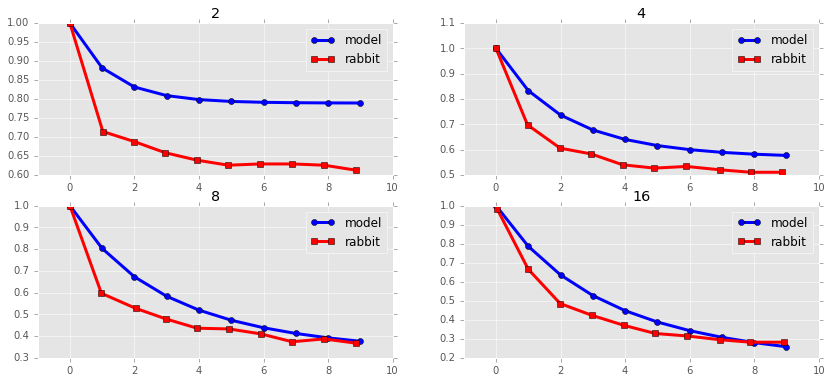

In [28]:
num_cols = np.floor(np.sqrt(len(test_freqs)))
num_rows = np.ceil(len(test_freqs) / num_cols)
plt.figure(figsize=(14, 6))
for i, freq in enumerate(test_freqs):
    freqstr = str(freq)
    plt.subplot(num_rows, num_cols, i + 1)
    if 'resp' in model[freqstr]:
        plt.plot(model[freqstr]['norm_resp'], 'o-b',
                 linewidth=3, label='model')
    if freqstr in freeman['norm_resp']:
        plt.plot(freeman['norm_resp'][freqstr][:, 0] - 1,
                 freeman['norm_resp'][freqstr][:, 1], 's-r',
                 linewidth=3, label='rabbit')
    plt.title(freqstr)
#     plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')

In [ ]:
# Using the Jensen-provided tau's for the double exponential
# [k1, k2, scale, bias] = x
# x: array([  1.42885311,  23.63057619,  10.        ,  -7.23240548])

# err=0.01276
# [k1, tau1, a, b, c, d] = x
# array([ 10.        ,   0.66614856,   0.08488603,  79.90961953, 1.25546999,  10.        ])

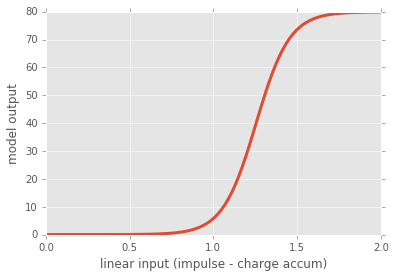

In [34]:
[k1, k2, a, b, c, d] = res.x
x = np.linspace(0, 2, 100)
y = a + (b - a) / (1.0 + np.exp((c - x) * d))
plt.plot(x, y, linewidth=3)
plt.xlabel('linear input (impulse - charge accum)')
plt.ylabel('model output')

In [35]:
def run_exp2(x, model):
    [k1, k2, a, b, c, d] = x
    pdur = 1.0 / 1000
    amp = 1
    freq = 16.0
    num_pulses = 300
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp2 = dict()
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=float(num_pulses) / freq,
                                  pulse_dur=pdur, interphase_dur=0,
                                  pulsetype='cathodicfirst',
                                  delay=20.0 / 1000)
    mov = gcr.model_cascade(stim)
    exp2['gcr'] = gcr
    exp2['mov'] = mov
    
    resp = np.squeeze(mov.data)
    freq_size = int(resp.size / float(num_pulses))
    peaks = []
    for f in range(num_pulses):
        slc = resp[f*freq_size: (f + 1) * freq_size]
        peaks.append(slc.max())

    exp2['t_resp'] = np.arange(num_pulses) / freq
    exp2['resp'] = peaks
    exp2['norm_resp'] = peaks / (peaks[0] + np.finfo(float).eps)
        
    return exp2

In [36]:
def mse_model_exp2(x, freeman):
    model = get_model(x)
    exp2 = run_exp2(x, model)

    # Linear interpolation between data points
    f = interp1d(exp2['t_resp'], exp2['resp'], fill_value='extrapolate')
    
    # Normalize Freeman response
    norm_freeman = freeman['long_term'][:, 1] / freeman['long_term'][0, 1]
    
    # Interpolate model at Freeman data points
    mse = np.mean(np.abs(norm_freeman - f(freeman['long_term'][:, 0])) ** 2)
    print('%s: %.7f' % (str([('%.7f' % x) for x in res.x]), mse))
    return mse

In [39]:
mse_model_exp2(res.x, freeman)

['10.0000000', '0.6661486', '0.0848860', '79.9096195', '1.2554700', '10.0000000']: 0.1691238


0.16912377485162314